#Boiler Plate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#Load Orginal Data

In [ ]:
#Load in the clinical data for each of the deidentified patients
patientData = pd.read_excel( "/content/drive/My Drive/ECMOProj/patientDataCombo.xlsx", engine='openpyxl', sheet_name = 0)

patientData = patientData[patientData["sent"] == "y"]
patientData.index = patientData["record_id"]


In [ ]:
#All deidentified patient perfusion data. 
o = open("/content/drive/My Drive/ECMOProj/AllNorm.pkl", "rb")
totalNormed = pickle.load(o)

#Create time-based pairs

In [ ]:
aliveIDs = list(set(patientData[patientData["ecmo_successful"]==1]["record_id"]))
decIDs = list(set(patientData[patientData["ecmo_successful"]==0]["record_id"]))

alive = pd.DataFrame(np.zeros([91,2]), columns = ['Id', 'Val'])
dec = pd.DataFrame(np.zeros([29,2]), columns = ['Id', 'Val'])


In [ ]:
for i,x in enumerate(aliveIDs):
  x = int(x)
  if str(x) not in totalNormed.keys():
    continue
  alive.iloc[i] = [x,totalNormed[str(x)]["start_time_seconds"].ffill().iloc[-1]]

alive = alive[alive["Id"]!=0]
alive.sort_values("Val",inplace=True)
alive.index = np.arange(len(alive))
alive["Pairs"] = (alive.index/3).astype(int)

for i,x in enumerate(decIDs):
  x = int(x)
  if str(x) not in totalNormed.keys():
    continue
  dec.iloc[i] = [x,totalNormed[str(x)]["start_time_seconds"].ffill().iloc[-1]]

dec = dec[dec["Id"]!=0]
dec.sort_values("Val",inplace=True)
dec.index = np.arange(len(dec))
dec["Pairs"] = (dec.index/3).astype(int)

In [ ]:
alive ## 30 Alive triplets
dec ## 9 Dec triplets
##So in total there should be 39*8 = 312 Gaussian Process Models
## Dictionary with keys alive0, alive1, ..., alive44, dec0, dec1,..., dec13. Each keys points to a list of eight Gaussian process models, one for each feature

,Id,Val,Pairs
0,2007.0,1.704800e+04,0
1,2076.0,1.905600e+05,0
2,1042.0,2.467800e+05,0
3,2060.0,2.481480e+05,1
4,2001.0,2.784968e+05,1
5,2056.0,3.737475e+05,1
6,1016.0,6.592200e+05,2
7,1038.0,7.555710e+05,2
8,2035.0,9.878689e+05,2
9,2029.0,1.090007e+06,3


#Create Clinical Data

In [ ]:
patColsNum = ["ecmo_successful", 'age', 'sex','bmi'] 
finalPat = patientData[patColsNum]

#Create Gaussian Models

In [ ]:
colList = list(finalPat.columns)
colList.remove('ecmo_successful')
XClin = finalPat[colList]
XPerf = np.arange(2054).reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
XClinScaled = pd.DataFrame(StandardScaler().fit_transform(XClin), index = XClin.index.astype(int))
XPerfScaled = StandardScaler().fit_transform(XPerf)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, DotProduct
from copy import deepcopy

In [ ]:
columns = ['Delta P', 'PVen', 'Pump Flow', 'RPM', 'Sweep', 'flow_normalized', 'start_time_seconds', 'sweepflow_normalized']
kernelReg = RBF(length_scale_bounds="fixed",length_scale = 1)
kernelLarge = RBF(length_scale_bounds="fixed",length_scale = 100)

In [ ]:
for x in range(alive["Pairs"].max()+1):
  triplet = list(alive[alive["Pairs"]==x]["Id"].astype(int))
  patientOne = totalNormed[str(triplet[0])]
  patientTwo = totalNormed[str(triplet[1])]
  patientThree = totalNormed[str(triplet[2])]
  GaussianInputOne = np.append(np.repeat([XClinScaled.loc[triplet[0]]], 2054, axis = 0), XPerfScaled, axis = 1)
  GaussianInputTwo = np.append(np.repeat([XClinScaled.loc[triplet[1]]], 2054, axis = 0), XPerfScaled, axis = 1)
  GaussianInputThree = np.append(np.repeat([XClinScaled.loc[triplet[2]]], 2054, axis = 0), XPerfScaled, axis = 1)
  X = np.append(np.append(GaussianInputOne, GaussianInputTwo, axis = 0), GaussianInputThree, axis = 0)

  tempGaussReg = []
  tempGaussLarge = []
  for j in columns:
    print("Triplet: "+str(x)+" "+ " Column: " + j)
    GaussianOutputOne = patientOne[j].ffill().fillna(value = 0)
    GaussianOutputTwo = patientTwo[j].ffill().fillna(value = 0)
    GaussianOutputThree = patientThree[j].ffill().fillna(value = 0)
    Y = np.append(np.append(GaussianOutputOne, GaussianOutputTwo),GaussianOutputThree).reshape(-1,1)

    gprReg = GaussianProcessRegressor(kernel = kernelReg, random_state=0, normalize_y = True).fit(X,Y)
    gprLarge = GaussianProcessRegressor(kernel = kernelLarge, random_state=0, normalize_y = True).fit(X,Y)
    tempGaussReg.append(deepcopy(gprReg))
    tempGaussLarge.append(deepcopy(gprLarge))
  f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/alive{}.pkl".format(x),"wb")
  pickle.dump(tempGaussReg,f)
  f.close()
  f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/LargeAlive{}.pkl".format(x),"wb")
  pickle.dump(tempGaussLarge,f)
  f.close()
  del tempGaussReg
  del tempGaussLarge
  while(gc.collect()>0):
    continue



Triplet: 0  Column: Delta P
Triplet: 0  Column: PVen
Triplet: 0  Column: Pump Flow
Triplet: 0  Column: RPM
Triplet: 0  Column: Sweep
Triplet: 0  Column: flow_normalized
Triplet: 0  Column: start_time_seconds
Triplet: 0  Column: sweepflow_normalized
Triplet: 1  Column: Delta P
Triplet: 1  Column: PVen
Triplet: 1  Column: Pump Flow
Triplet: 1  Column: RPM
Triplet: 1  Column: Sweep
Triplet: 1  Column: flow_normalized
Triplet: 1  Column: start_time_seconds
Triplet: 1  Column: sweepflow_normalized
Triplet: 2  Column: Delta P
Triplet: 2  Column: PVen
Triplet: 2  Column: Pump Flow
Triplet: 2  Column: RPM
Triplet: 2  Column: Sweep
Triplet: 2  Column: flow_normalized
Triplet: 2  Column: start_time_seconds
Triplet: 2  Column: sweepflow_normalized
Triplet: 3  Column: Delta P
Triplet: 3  Column: PVen
Triplet: 3  Column: Pump Flow
Triplet: 3  Column: RPM
Triplet: 3  Column: Sweep
Triplet: 3  Column: flow_normalized
Triplet: 3  Column: start_time_seconds
Triplet: 3  Column: sweepflow_normalized
Trip

In [ ]:
for x in range(dec["Pairs"].max()):
  triplet = list(dec[dec["Pairs"]==x]["Id"].astype(int))
  patientOne = totalNormed[str(triplet[0])]
  patientTwo = totalNormed[str(triplet[1])]
  patientThree = totalNormed[str(triplet[2])]
  GaussianInputOne = np.append(np.repeat([XClinScaled.loc[triplet[0]]], 2054, axis = 0), XPerfScaled, axis = 1)
  GaussianInputTwo = np.append(np.repeat([XClinScaled.loc[triplet[1]]], 2054, axis = 0), XPerfScaled, axis = 1)
  GaussianInputThree = np.append(np.repeat([XClinScaled.loc[triplet[2]]], 2054, axis = 0), XPerfScaled, axis = 1)
  X = np.append(np.append(GaussianInputOne, GaussianInputTwo, axis = 0), GaussianInputThree, axis = 0)
  
  tempGaussReg = []
  tempGaussLarge = []
  for j in columns:
    print("Triplet: "+str(x)+" "+ " Column: " + j)
    GaussianOutputOne = patientOne[j].ffill().fillna(value = 0)
    GaussianOutputTwo = patientTwo[j].ffill().fillna(value = 0)
    GaussianOutputThree = patientThree[j].ffill().fillna(value = 0)
    Y = np.append(np.append(GaussianOutputOne, GaussianOutputTwo),GaussianOutputThree).reshape(-1,1)

    gprReg = GaussianProcessRegressor(kernel = kernelReg, random_state=0, normalize_y = True).fit(X,Y)
    gprLarge = GaussianProcessRegressor(kernel = kernelLarge, random_state=0, normalize_y = True).fit(X,Y)
    tempGaussReg.append(deepcopy(gprReg))
    tempGaussLarge.append(deepcopy(gprLarge))
  f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/dec{}.pkl".format(x),"wb")
  pickle.dump(tempGaussReg,f)
  f.close()
  f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/LargeDec{}.pkl".format(x),"wb")
  pickle.dump(tempGaussLarge,f)
  f.close()
  del tempGaussReg
  del tempGaussLarge
  while(gc.collect()>0):
    continue


Triplet: 0  Column: Delta P
Triplet: 0  Column: PVen
Triplet: 0  Column: Pump Flow
Triplet: 0  Column: RPM
Triplet: 0  Column: Sweep
Triplet: 0  Column: flow_normalized
Triplet: 0  Column: start_time_seconds
Triplet: 0  Column: sweepflow_normalized
Triplet: 1  Column: Delta P
Triplet: 1  Column: PVen
Triplet: 1  Column: Pump Flow
Triplet: 1  Column: RPM
Triplet: 1  Column: Sweep
Triplet: 1  Column: flow_normalized
Triplet: 1  Column: start_time_seconds
Triplet: 1  Column: sweepflow_normalized
Triplet: 2  Column: Delta P
Triplet: 2  Column: PVen
Triplet: 2  Column: Pump Flow
Triplet: 2  Column: RPM
Triplet: 2  Column: Sweep
Triplet: 2  Column: flow_normalized
Triplet: 2  Column: start_time_seconds
Triplet: 2  Column: sweepflow_normalized
Triplet: 3  Column: Delta P
Triplet: 3  Column: PVen
Triplet: 3  Column: Pump Flow
Triplet: 3  Column: RPM
Triplet: 3  Column: Sweep
Triplet: 3  Column: flow_normalized
Triplet: 3  Column: start_time_seconds
Triplet: 3  Column: sweepflow_normalized
Trip

#Create Data from Gaussian Models

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#There are 30 triplets of alive patients and 8 triplets of deceased patients. 
#For the training/val/test split, this can be divided into 18/6/6 and 3/1/1
#For the training data set we can sample 3 each from 18 and 18 from 3 for a total of 108
#For the validation/test data set we can sample 3 from 6 and 18 from 1 for a total of 36 
#Which triplets go in each group can be randomized 
trainingTriplets = np.zeros([12,5,21])
validationTriplets = np.zeros([12,5,7])
testTriplets = np.zeros([12,5,7])

trainingClinical = np.zeros([12,5,108, 3])
validationClinical = np.zeros([12,5,36, 3])
testClinical = np.zeros([12,5,36, 3])

trainingPerfusion = np.zeros([12,5,108,2054, 8])
validationPerfusion = np.zeros([12,5,36,2054, 8])
testPerfusion = np.zeros([12,5,36,2054, 8])

trainingPerfusionLarge = np.zeros([12,5,108,2054, 8])
validationPerfusionLarge = np.zeros([12,5,36,2054, 8])
testPerfusionLarge = np.zeros([12,5,36,2054, 8])

In [ ]:
#Create the arrays of triplet IDs for each crossvalidation

for x in range(12):
  np.random.seed(x) #By using x as the seed, this makes it repeatable
  aliveIndex = np.arange(30)
  decIndex = np.arange(8)+30
  np.random.shuffle(aliveIndex)
  np.random.shuffle(decIndex)

  #Truncate indices into a length divisible by 5 in order to makes the folds works
  aliveIndex = aliveIndex[:int(len(aliveIndex)/5)*5]
  decIndex = decIndex[:int(len(decIndex)/5)*5]

  #Split the indices into five groups
  aliveFolds = np.array(np.split(aliveIndex, 5))
  decFolds = np.array(np.split(decIndex, 5))

  for j in range(5):
    testTriplets[x,j] = np.append(aliveFolds[j], decFolds[j])
    validationTriplets[x,j] = np.append(aliveFolds[(j+1)%5], decFolds[(j+1)%5])
    
    leftOver = np.setdiff1d(np.setdiff1d(np.arange(5), j), (j+1)%5)
    trainingTriplets[x,j] = np.append(aliveFolds[leftOver], decFolds[leftOver])



In [ ]:
#Create the arrays of clinicalInfo for each crossvalidation

np.random.seed(0)
# clinicalInfo = np.append(np.random.normal(size = 30*3*3).reshape(90,3), np.random.normal(size = 8*18*3).reshape(144,3), axis =0)
aliveNoise = XClinScaled.loc[alive["Id"]].to_numpy() + np.random.normal(size = 30*3*3, scale = 0.01).reshape(90,3)
decNoise = np.repeat(XClinScaled.loc[dec[dec["Pairs"]<8]["Id"]].to_numpy(), 6, axis = 0) + np.random.normal(size = 18*8*3, scale = 0.01).reshape(144,3)
clinicalInfo = np.append(aliveNoise, decNoise, axis = 0)

for x in range(12):
  for j in range(5):
    triplePatient = (np.repeat([trainingTriplets[x,j,:18]*3], 3, axis = 0).T + np.repeat([np.arange(3)],18, axis = 0)).reshape(-1)
    eighteenPatient = (np.repeat([(trainingTriplets[x,j,18:]-30)*18], 18, axis = 0).T + np.repeat([np.arange(18)],3, axis = 0) +90).reshape(-1)
    allPatients = np.append(triplePatient,eighteenPatient)
    trainingClinical[x,j] = clinicalInfo[allPatients.astype(int)]

    triplePatient = (np.repeat([validationTriplets[x,j,:6]*3], 3, axis = 0).T + np.repeat([np.arange(3)],6, axis = 0)).reshape(-1)
    eighteenPatient = (np.repeat([(validationTriplets[x,j,6:]-30)*18], 18, axis = 0).T + np.repeat([np.arange(18)],1, axis = 0) +90).reshape(-1)
    allPatients = np.append(triplePatient,eighteenPatient)
    validationClinical[x,j] = clinicalInfo[allPatients.astype(int)]

    triplePatient = (np.repeat([testTriplets[x,j,:6]*3], 3, axis = 0).T + np.repeat([np.arange(3)],6, axis = 0)).reshape(-1)
    eighteenPatient = (np.repeat([(testTriplets[x,j,6:]-30)*18], 18, axis = 0).T + np.repeat([np.arange(18)],1, axis = 0) +90).reshape(-1)
    allPatients = np.append(triplePatient,eighteenPatient)
    testClinical[x,j] = clinicalInfo[allPatients.astype(int)]

    

In [ ]:
perfusionXInput = np.arange(2054).reshape(-1,1)
perfusionXInput = StandardScaler().fit_transform(perfusionXInput)

In [ ]:
allPatientPerfusion = np.zeros([30*3 + 8*18, 2054, 8])
allPatientPerfusionLarge = np.zeros([30*3 + 8*18, 2054, 8])
allPatientPerfusionSmall = np.zeros([30*3 + 8*18, 2054, 8])
for x in range(30):
  print("alive: " + str(x))
  o = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/alive{}.pkl".format(x), "rb")
  aliveGaussArray = pickle.load(o)
  o = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/LargeAlive{}.pkl".format(x), "rb")
  aliveGaussArrayLarge = pickle.load(o)
  for j in range(3):
    clinicalInfoIndiv = clinicalInfo[x*3+j]
    X = np.append(np.repeat([clinicalInfoIndiv], 2054, axis =0), perfusionXInput, axis = 1)
    for k in range(8):
      sample = aliveGaussArray[k].predict(X)
      sampleLarge = aliveGaussArrayLarge[k].predict(X)
      allPatientPerfusion[x*3+j,:,k] = sample.reshape(-1)
      allPatientPerfusionLarge[x*3+j,:,k] = sampleLarge.reshape(-1)
  del aliveGaussArray
  del aliveGaussArrayLarge
# 
for x in range(8):
  print("dec: " + str(x))
  o = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/dec{}.pkl".format(x), "rb")
  decGaussArray = pickle.load(o)
  o = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/LargeDec{}.pkl".format(x), "rb")
  decGaussArrayLarge = pickle.load(o)
  for j in range(18):
    clinicalInfoIndiv = clinicalInfo[90+x*18+j]
    X = np.append(np.repeat([clinicalInfoIndiv], 2054, axis =0), perfusionXInput, axis = 1)
    for k in range(8):
      sample = decGaussArray[k].predict(X)
      sampleLarge = decGaussArrayLarge[k].predict(X)
      allPatientPerfusion[90+x*18+j,:,k] = sample.reshape(-1)
      allPatientPerfusionLarge[90+x*18+j,:,k] = sampleLarge.reshape(-1)
  del decGaussArray
  del decGaussArrayLarge




alive: 0
alive: 1
alive: 2
alive: 3
alive: 4
alive: 5
alive: 6
alive: 7
alive: 8
alive: 9
alive: 10
alive: 11
alive: 12
alive: 13
alive: 14
alive: 15
alive: 16
alive: 17
alive: 18
alive: 19
alive: 20
alive: 21
alive: 22
alive: 23
alive: 24
alive: 25
alive: 26
alive: 27
alive: 28
alive: 29
dec: 0
dec: 1
dec: 2
dec: 3
dec: 4
dec: 5
dec: 6
dec: 7


In [ ]:
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/allPatientPerfusionCloseClin.pkl","wb")
# pickle.dump(allPatientPerfusion,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/allPatientPerfusionLargeCloseClin.pkl","wb")
# pickle.dump(allPatientPerfusionLarge,f)
# f.close()

Can be found here: https://anonymous.4open.science/status/CHILData-4164

In [ ]:
o = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/allPatientPerfusionCloseClin.pkl", "rb")
allPatientPerfusion = pickle.load(o)
o = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/allPatientPerfusionLargeCloseClin.pkl", "rb")
allPatientPerfusionLarge = pickle.load(o)

In [ ]:
for x in range(12):
  for j in range(5):
    triplePatient = (np.repeat([trainingTriplets[x,j,:18]*3], 3, axis = 0).T + np.repeat([np.arange(3)],18, axis = 0)).reshape(-1)
    eighteenPatient = (np.repeat([(trainingTriplets[x,j,18:]-30)*18], 18, axis = 0).T + np.repeat([np.arange(18)],3, axis = 0) +90).reshape(-1)
    allPatients = np.append(triplePatient,eighteenPatient)
    trainingPerfusion[x,j] = allPatientPerfusion[allPatients.astype(int)]
    trainingPerfusionLarge[x,j] = allPatientPerfusionLarge[allPatients.astype(int)]

    triplePatient = (np.repeat([validationTriplets[x,j,:6]*3], 3, axis = 0).T + np.repeat([np.arange(3)],6, axis = 0)).reshape(-1)
    eighteenPatient = (np.repeat([(validationTriplets[x,j,6:]-30)*18], 18, axis = 0).T + np.repeat([np.arange(18)],1, axis = 0) +90).reshape(-1)
    allPatients = np.append(triplePatient,eighteenPatient)
    validationPerfusion[x,j] = allPatientPerfusion[allPatients.astype(int)]
    validationPerfusionLarge[x,j] = allPatientPerfusionLarge[allPatients.astype(int)]

    triplePatient = (np.repeat([testTriplets[x,j,:6]*3], 3, axis = 0).T + np.repeat([np.arange(3)],6, axis = 0)).reshape(-1)
    eighteenPatient = (np.repeat([(testTriplets[x,j,6:]-30)*18], 18, axis = 0).T + np.repeat([np.arange(18)],1, axis = 0) +90).reshape(-1)
    allPatients = np.append(triplePatient,eighteenPatient)
    testPerfusion[x,j] = allPatientPerfusion[allPatients.astype(int)]
    testPerfusionLarge[x,j] = allPatientPerfusionLarge[allPatients.astype(int)]
    

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Standardize Data
for x in range(12):
  for j in range(5):
    scal = MinMaxScaler()
    trainingPerfusion[x,j] = scal.fit_transform(trainingPerfusion[x,j].reshape(-1,8)).reshape(trainingPerfusion[x,j].shape)
    validationPerfusion[x,j] = scal.transform(validationPerfusion[x,j].reshape(-1,8)).reshape(validationPerfusion[x,j].shape)
    testPerfusion[x,j] = scal.transform(testPerfusion[x,j].reshape(-1,8)).reshape(testPerfusion[x,j].shape)

    scalLarge = MinMaxScaler()
    trainingPerfusionLarge[x,j] = scalLarge.fit_transform(trainingPerfusionLarge[x,j].reshape(-1,8)).reshape(trainingPerfusionLarge[x,j].shape)
    validationPerfusionLarge[x,j] = scalLarge.transform(validationPerfusionLarge[x,j].reshape(-1,8)).reshape(validationPerfusionLarge[x,j].shape)
    testPerfusionLarge[x,j] = scalLarge.transform(testPerfusionLarge[x,j].reshape(-1,8)).reshape(testPerfusionLarge[x,j].shape)


In [ ]:
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/trainingPerfusionCloseClin.pkl","wb")
# pickle.dump(trainingPerfusion,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/validationPerfusionCloseClin.pkl","wb")
# pickle.dump(validationPerfusion,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/testPerfusionCloseClin.pkl","wb")
# pickle.dump(testPerfusion,f)
# f.close()

# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/trainingPerfusionLargeCloseClin.pkl","wb")
# pickle.dump(trainingPerfusionLarge,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/validationPerfusionLargeCloseClin.pkl","wb")
# pickle.dump(validationPerfusionLarge,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/testPerfusionLargeCloseClin.pkl","wb")
# pickle.dump(testPerfusionLarge,f)
# f.close()


In [ ]:
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/trainingClinicalCloseClin.pkl","wb")
# pickle.dump(trainingClinical,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/validationClinicalCloseClin.pkl","wb")
# pickle.dump(validationClinical,f)
# f.close()
# f = open("/content/drive/My Drive/ECMOProj/GaussianProcessForArtData/testClinicalCloseClin.pkl","wb")
# pickle.dump(testClinical,f)
# f.close()

#TSNE

In [ ]:
allPatientPerfusion.shape

(234, 2054, 8)

In [ ]:
original = np.zeros([0,2054,8])
for x in totalNormed:
  original = np.append(original,[totalNormed[x].ffill().fillna(0)], axis = 0 )
original.shape

(121, 2054, 8)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
scal = MinMaxScaler()
originalScal = scal.fit_transform(original.reshape(-1,8)).reshape(original.shape)
allPatientPerfusionScal = scal.transform(allPatientPerfusion.reshape(-1,8)).reshape(allPatientPerfusion.shape)
allPatientPerfusionLargeScal = scal.transform(allPatientPerfusionLarge.reshape(-1,8)).reshape(allPatientPerfusionLarge.shape)

In [ ]:
semiSetWithOrig = np.append(np.append(allPatientPerfusionScal.reshape(-1,2054*8), allPatientPerfusionLargeScal.reshape(-1,2054*8), axis = 0), originalScal.reshape(-1, 2054*8), axis = 0)
semiSet = np.append(allPatientPerfusionScal.reshape(-1,2054*8), allPatientPerfusionLargeScal.reshape(-1,2054*8), axis = 0)


In [ ]:
columns = ['Delta Pressure',
 'Venous Pressure',
 'Pump Flow',
 'RPM',
 'Sweep',
 'Pump Flow Normalized to BMI',
 'Seconds on ECMO',
 'Sweep Normalized to Flow']

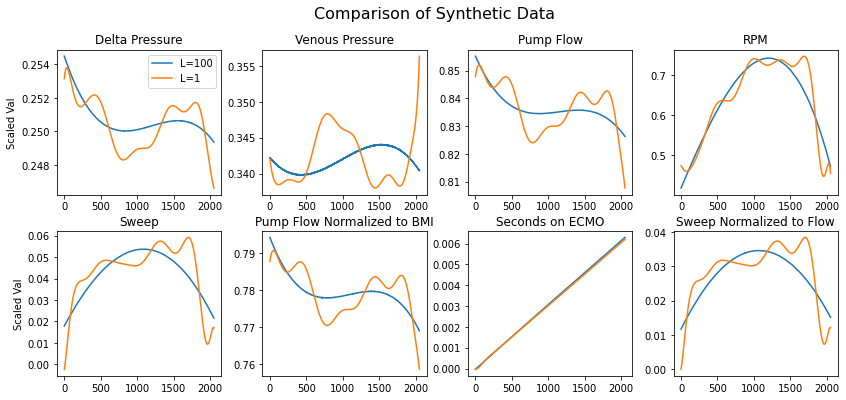

In [ ]:

fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (14,6))
fig.suptitle('Comparison of Synthetic Data', fontsize = 16)
fig.subplots_adjust(hspace=0.25, wspace = 0.25)
for x in range(8):
  ax[int(x/4)][x%4].plot(allPatientPerfusionLargeScal[1,:,x], label = "L=100")
  ax[int(x/4)][x%4].plot(allPatientPerfusionScal[1,:,x], label = "L=1")
  ax[int(x/4)][x%4].set_title(columns[x])
  if(x%4 == 0):
    ax[int(x/4)][x%4].set_ylabel("Scaled Val")
  if(int(x/4)==2):
    ax[int(x/4)][x%4].set_xlabel("Time Step")
  if(x==0):
    ax[int(x/4)][x%4].legend()






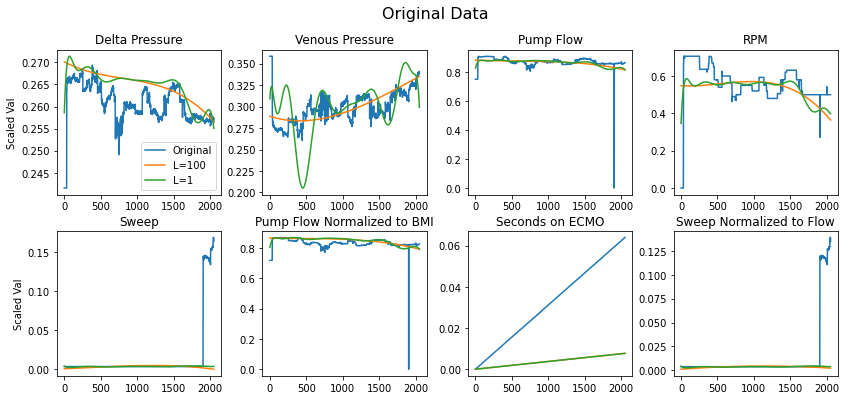

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (14,6))
fig.suptitle('Original Data', fontsize = 16)
fig.subplots_adjust(hspace=0.25, wspace = 0.25)
for x in range(8):
  ax[int(x/4)][x%4].plot(originalScal[0,:,x], label = "Original")
  ax[int(x/4)][x%4].plot(allPatientPerfusionLargeScal[2,:,x], label = "L=100")
  ax[int(x/4)][x%4].plot(allPatientPerfusionScal[2,:,x], label = "L=1")
  ax[int(x/4)][x%4].set_title(columns[x])
  if(x%4 == 0):
    ax[int(x/4)][x%4].set_ylabel("Scaled Val")
  if(int(x/4)==2):
    ax[int(x/4)][x%4].set_xlabel("Time Step")
  if(x==0):
    ax[int(x/4)][x%4].legend()

In [ ]:
cols = totalNormed["1001"].columns

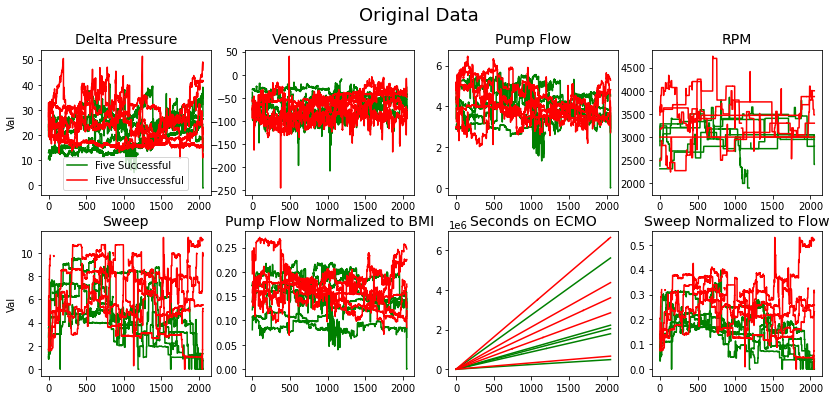

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (14,6))
fig.suptitle('Original Data', fontsize = 18)
fig.subplots_adjust(hspace=0.25)
for x in range(8):
  ax[int(x/4)][x%4].plot(totalNormed["1001"][cols[x]], label = "Five Successful", c = "green")
  ax[int(x/4)][x%4].plot(totalNormed["1003"][cols[x]], c = "green")
  ax[int(x/4)][x%4].plot(totalNormed["1005"][cols[x]], c = "green")
  ax[int(x/4)][x%4].plot(totalNormed["1007"][cols[x]], c = "green")
  ax[int(x/4)][x%4].plot(totalNormed["1008"][cols[x]], c = "green")

  ax[int(x/4)][x%4].plot(totalNormed["1019"][cols[x]], label = "Five Unsuccessful", c = "red")
  ax[int(x/4)][x%4].plot(totalNormed["1010"][cols[x]], c = "red")
  ax[int(x/4)][x%4].plot(totalNormed["1011"][cols[x]], c = "red")
  ax[int(x/4)][x%4].plot(totalNormed["1012"][cols[x]], c = "red")
  ax[int(x/4)][x%4].plot(totalNormed["1016"][cols[x]], c = "red")
  ax[int(x/4)][x%4].set_title(columns[x], fontsize = 14)
  if(x%4 == 0):
    ax[int(x/4)][x%4].set_ylabel("Val")
  if(int(x/4)==2):
    ax[int(x/4)][x%4].set_xlabel("Time Step")
  if(x==0):
    ax[int(x/4)][x%4].legend()

In [ ]:
TSNESynth = TSNE(random_state = 0).fit_transform(semiSetWithOrig)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
allPatientPerfusionScal.shape

(234, 2054, 8)

In [ ]:
TSNESynth.shape

(589, 2)

In [ ]:
colorScheme = ['red']*234
colorSchemeGreen = ['green']*234
colorSchemeBlue = ['blue']*121
colorScheme = colorScheme+colorSchemeGreen+ colorSchemeBlue

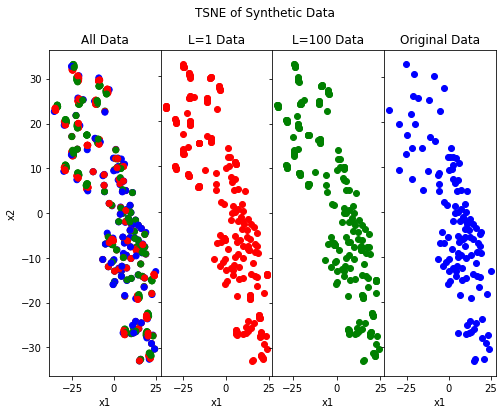

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (8,6))
fig.suptitle('TSNE of Synthetic Data')
fig.subplots_adjust(wspace=0)

ax[1].scatter(TSNESynth[:234,0], TSNESynth[:234,1], c = "red", label = "L=1")
ax[1].set_title("L=1 Data")
ax[1].set_xlabel("x1")
ax[2].scatter(TSNESynth[234:468,0], TSNESynth[234:468,1], c = "green", label = "L=100")
ax[2].set_title("L=100 Data")
ax[2].set_xlabel("x1")
ax[3].scatter(TSNESynth[468:,0], TSNESynth[468:,1], c = "blue", label = "Original")
ax[3].set_title("Original Data")
ax[3].set_xlabel("x1")

np.random.seed(0)
randomIndices = np.arange(589).astype(int)
np.random.shuffle(randomIndices)
ax[0].scatter(TSNESynth[randomIndices,0], TSNESynth[randomIndices,1], c = [colorScheme[i] for i in randomIndices])
ax[0].set_title("All Data")
ax[0].set_ylabel("x2")
ax[0].set_xlabel("x1")


for ax in fig.get_axes():
    ax.label_outer()